In [32]:
import pandas as pd
import numpy as np
from scipy.stats import norm 
from models import *
import matplotlib.pyplot as plt

In [3]:
test_demographics = pd.read_csv('../data/raw/s4/demo.csv', parse_dates=['reg_date'], infer_datetime_format=True)
test_results = pd.read_csv('../data/raw/s4/ab_test_results.csv', parse_dates=['date'], infer_datetime_format=True)

In [4]:
test_demographics.head()

,uid,reg_date,device,gender,country,age
0,52774929.0,2018-03-07,and,F,FRA,27
1,84341593.0,2017-09-22,iOS,F,TUR,22
2,41201055.0,2017-11-24,and,F,USA,20
3,68477880.0,2016-12-08,and,F,BRA,18
4,42235969.0,2017-09-30,and,F,USA,41


In [5]:
# Group column: C for control; V for variant
test_results.head()

,uid,date,purchase,sku,price,group
0,82082526.0,2018-02-15 06:24:30,0,NaN,NaN,V
1,82082526.0,2018-02-16 21:52:38,0,NaN,NaN,V
2,82082526.0,2018-02-17 03:17:59,0,NaN,NaN,V
3,82082526.0,2018-02-18 18:16:27,0,NaN,NaN,V
4,82082526.0,2018-02-19 02:12:14,0,NaN,NaN,V


In [6]:
test_results.groupby(by='group', as_index=False).uid.count()

,group,uid
0,C,58583
1,V,56350


In [7]:
test_result_demo = test_results.merge(test_demographics, how='inner', on='uid')

test_result_demo.groupby(by=['country', 'gender', 'device','group'], as_index=False).uid.count().head(5)

,country,gender,device,group,uid
0,BRA,F,and,C,5070
1,BRA,F,and,V,4136
2,BRA,F,iOS,C,3359
3,BRA,F,iOS,V,2817
4,BRA,M,and,C,3562


In [8]:
test_result_group = test_result_demo.groupby(by='group', as_index=False).agg({'purchase':['count','sum']})
test_result_group.columns = test_result_group.columns.droplevel(0)
test_result_group['conv'] = test_result_group['sum'] / test_result_group['count']
test_result_group.head()

,,count,sum,conv
0,C,58583,5329,0.090965
1,V,56350,5748,0.102005


In [13]:
p1, p2 = test_result_group['conv']
m, n = test_result_group['count']
q1 = (1-p1)
q2 = (1-p2)

In [26]:
p_hat = (m * p1 + n * p2) / (m + n)
q_hat = (1-p_hat)

z1 = 2 * ((p1 - p2) / (p_hat*q_hat*(1/m+1/n)) ** 0.5)
z2 = 2 * (p1 - p2) / ((p1 * q1 / m + p2 * q2 / n ) ** 0.5)
print(norm.cdf(z1, loc=0))
print(norm.cdf(z2, loc=0))

3.78465378141395e-37
4.319921718963471e-37


In [27]:
get_pvalue(p1,p2,m,n)

2.3712097932400415e-10

In [28]:
cont_conv = p1
cont_var = p1 * q1 * m

test_conv = p2
test_var = p2 * q2 * n

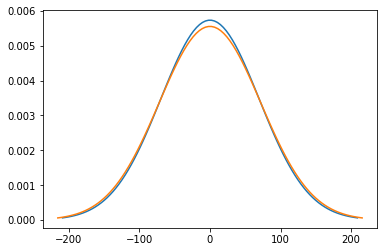

In [29]:
# Compute the standard deviations
control_sd = cont_var**0.5
test_sd = test_var**0.5

# Create the range of x values 
control_line = np.linspace(cont_conv - 3 * control_sd, cont_conv + 3 * control_sd, 100)
test_line = np.linspace(test_conv - 3 * test_sd ,test_conv +  3 * test_sd, 100)

# Plot the distribution     
plt.plot(control_line, norm.pdf(control_line, cont_conv, control_sd))
plt.plot(test_line, norm.pdf(test_line, test_conv, test_sd))
plt.show()

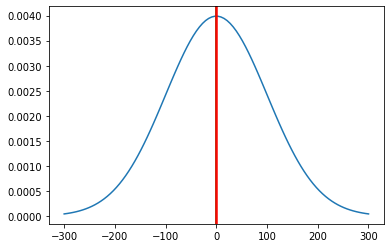

In [33]:
# Find the lift statistics
lift_mean = test_conv - cont_conv
lift_sd = (test_var + cont_var) ** 0.5

lwr_ci, upr_ci = get_ci(lift_mean, 0.95, lift_sd)

# Generate the range of x-values
lift_line = np.linspace(lift_mean - 3 * lift_sd, lift_mean + 3 * lift_sd, 100)

# Plot the distribution 
plt.plot(lift_line, norm.pdf(lift_line, lift_mean, lift_sd))

# Add the annotation lines
plt.axvline(x = lift_mean, color = 'green')
plt.axvline(x = lwr_ci, color = 'red')
plt.axvline(x = upr_ci, color = 'red')
plt.show()